<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Algorithmic Trading 

**Chapter 05 &mdash; Predicting Market Movements with Machine Learning**

## Using Linear Regression for Market Movement Prediction

### A Quick Review of Linear Regression

In [2]:
import os
import random
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASHSEED'] = '0'

/tmp/ipykernel_9246/987665674.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
x = np.linspace(0, 10)

In [4]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
set_seeds() # <4>

In [5]:
y = x + np.random.standard_normal(len(x))

In [6]:
reg = np.polyfit(x, y, deg=1)

In [7]:
reg

array([0.94612934, 0.22855261])

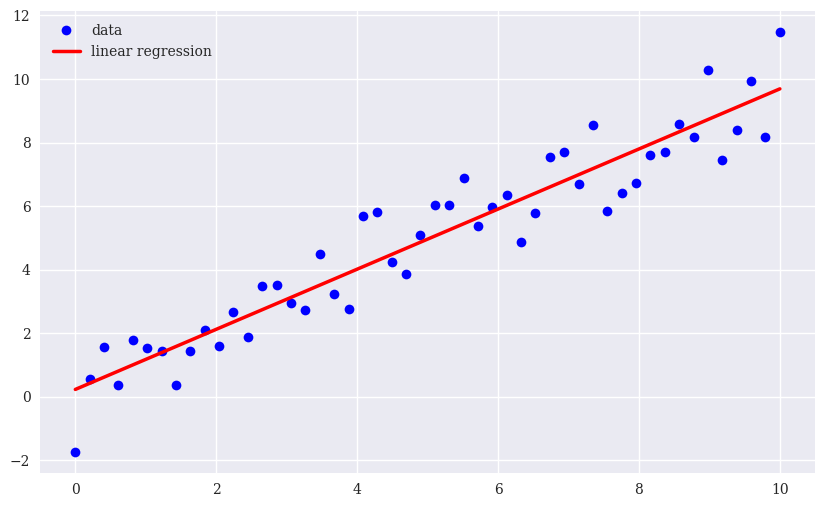

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='data')
plt.plot(x, np.polyval(reg, x), 'r', lw=2.5,
         label='linear regression')
plt.legend(loc=0);
# plt.savefig('../../images/ch05/lr_plot_1.png')

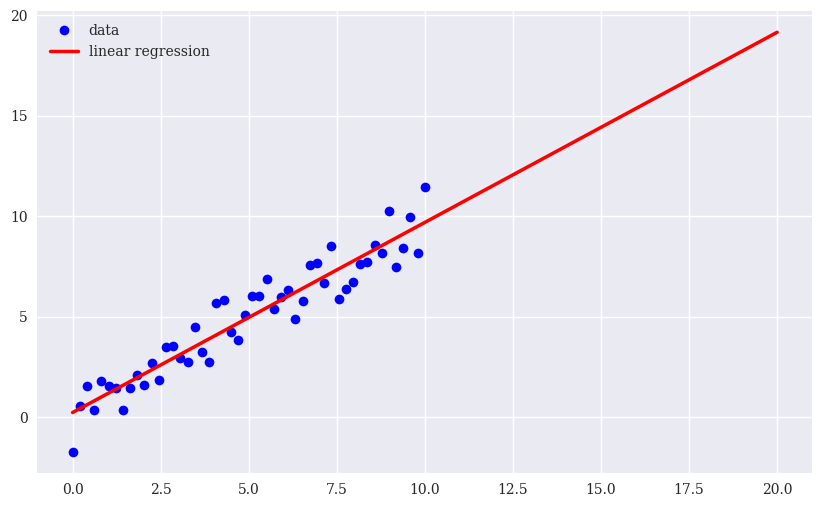

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='data')
xn = np.linspace(0, 20)
plt.plot(xn, np.polyval(reg, xn), 'r', lw=2.5,
         label='linear regression')
plt.legend(loc=0);
# plt.savefig('../../images/ch05/lr_plot_2.png')

### The Basic Idea for Price Prediction

In [10]:
x = np.arange(12)

In [11]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [12]:
lags = 3

In [15]:
m = np.zeros((lags + 1, len(x) - lags))

In [16]:
m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i:i - lags]

In [24]:
m.T

array([[ 0.,  1.,  2.,  3.],
       [ 1.,  2.,  3.,  4.],
       [ 2.,  3.,  4.,  5.],
       [ 3.,  4.,  5.,  6.],
       [ 4.,  5.,  6.,  7.],
       [ 5.,  6.,  7.,  8.],
       [ 6.,  7.,  8.,  9.],
       [ 7.,  8.,  9., 10.],
       [ 8.,  9., 10., 11.]])

In [18]:
reg = np.linalg.lstsq(m[:lags].T, m[lags], rcond=None)[0]

In [19]:
reg

array([-0.66666667,  0.33333333,  1.33333333])

In [20]:
np.dot(m[:lags].T, reg)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

### Predicting Index Levels

In [25]:
import pandas as pd

In [26]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [27]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [28]:
symbol = 'EUR='

In [29]:
data = pd.DataFrame(raw[symbol])

In [30]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [31]:
lags = 5

In [32]:
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['price'].shift(lag) # <1>
    cols.append(col)
data.dropna(inplace=True)

In [33]:
reg = np.linalg.lstsq(data[cols], data['price'],
                      rcond=None)[0]

In [34]:
reg

array([ 0.98635864,  0.02292172, -0.04769849,  0.05037365, -0.01208135])

In [35]:
data['prediction'] = np.dot(data[cols], reg)

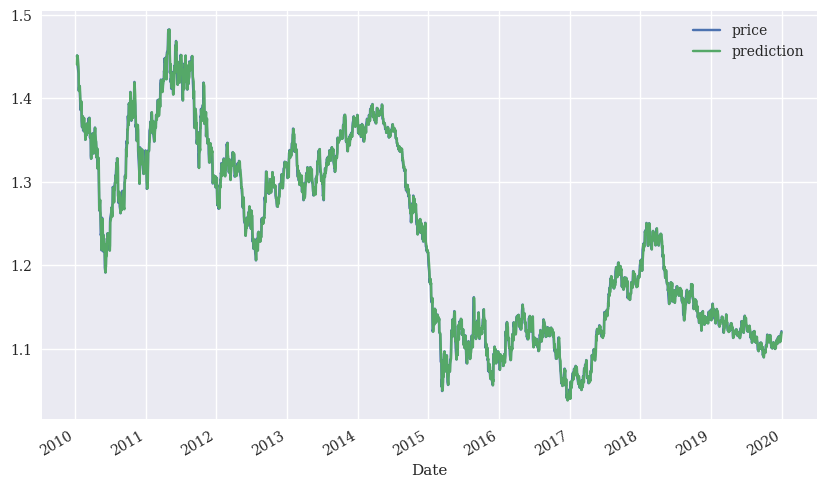

In [36]:
data[['price', 'prediction']].plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_3.png')

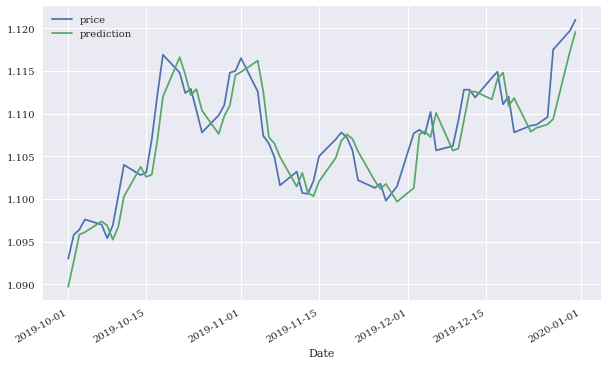

In [30]:
data[['price', 'prediction']].loc['2019-10-1':].plot(
            figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_4.png')

### Predicting Future Returns

In [37]:
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))

In [38]:
data.dropna(inplace=True)

In [39]:
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <3>
    cols.append(col)
data.dropna(inplace=True)

In [40]:
reg = np.linalg.lstsq(data[cols], data['return'],
                      rcond=None)[0]

In [41]:
reg

array([-0.015689  ,  0.00890227, -0.03634858,  0.01290924, -0.00636023])

In [42]:
data['prediction'] = np.dot(data[cols], reg)

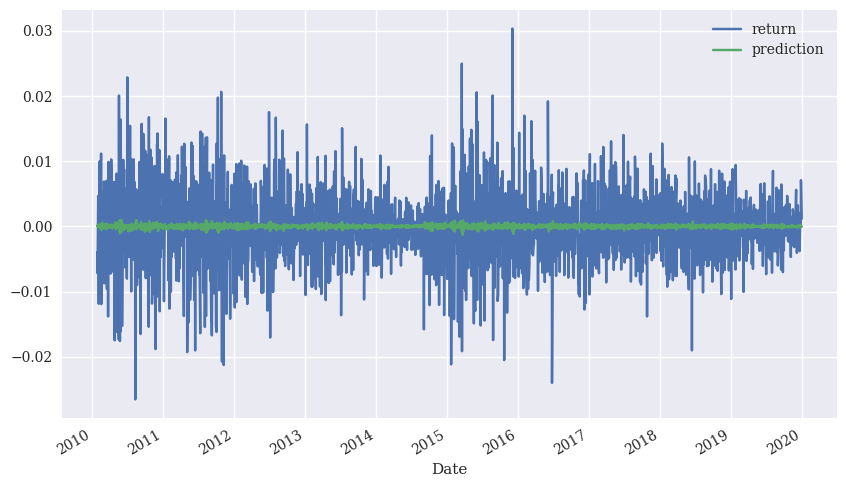

In [43]:
data[['return', 'prediction']].iloc[lags:].plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_5.png')

In [44]:
hits = np.sign(data['return'] *
               data['prediction']).value_counts()

In [45]:
hits

 1.0    1250
-1.0    1242
 0.0      13
dtype: int64

In [46]:
hits.values[0] / sum(hits)

0.499001996007984

### Prediction Future Market Direction

In [41]:
reg = np.linalg.lstsq(data[cols], np.sign(data['return']),
                      rcond=None)[0]

In [42]:
reg

array([-5.11938725, -2.24077248, -5.13080606, -3.03753232, -2.14819119])

In [43]:
data['prediction'] = np.sign(np.dot(data[cols], reg))

In [44]:
data['prediction'].value_counts()

 1.0    1300
-1.0    1205
Name: prediction, dtype: int64

In [45]:
hits = np.sign(data['return'] *
               data['prediction']).value_counts()

In [46]:
hits

 1.0    1301
-1.0    1191
 0.0      13
dtype: int64

In [47]:
hits.values[0] / sum(hits)

0.5193612774451097

### Vectorized Backtesting of Regression-based Strategy 

In [48]:
data.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5,prediction,return
Date,,,,,,,,
2010-01-20,1.4101,-0.005858,-0.008309,-0.000551,0.001103,-0.001310,1.0,-0.013874
2010-01-21,1.4090,-0.013874,-0.005858,-0.008309,-0.000551,0.001103,1.0,-0.000780
2010-01-22,1.4137,-0.000780,-0.013874,-0.005858,-0.008309,-0.000551,1.0,0.003330
2010-01-25,1.4150,0.003330,-0.000780,-0.013874,-0.005858,-0.008309,1.0,0.000919
2010-01-26,1.4073,0.000919,0.003330,-0.000780,-0.013874,-0.005858,1.0,-0.005457


In [49]:
data['strategy'] = data['prediction'] * data['return']

In [50]:
data[['return', 'strategy']].sum().apply(np.exp)

return      0.784026
strategy    1.654154
dtype: float64

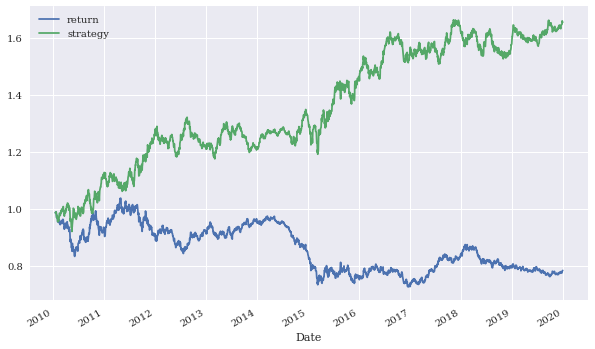

In [51]:
data[['return', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_6.png')

### Generalizing the Approach

In [52]:
import LRVectorBacktester as LR

In [53]:
lrbt = LR.LRVectorBacktester('EUR=', '2010-1-1', '2019-12-31',
                                     10000, 0.0)

In [54]:
lrbt.run_strategy('2010-1-1', '2019-12-31',
                  '2010-1-1', '2019-12-31', lags=5)

(17166.53, 9442.42)

In [55]:
lrbt.run_strategy('2010-1-1', '2017-12-31',
                  '2018-1-1', '2019-12-31', lags=5)

(10160.86, 791.87)

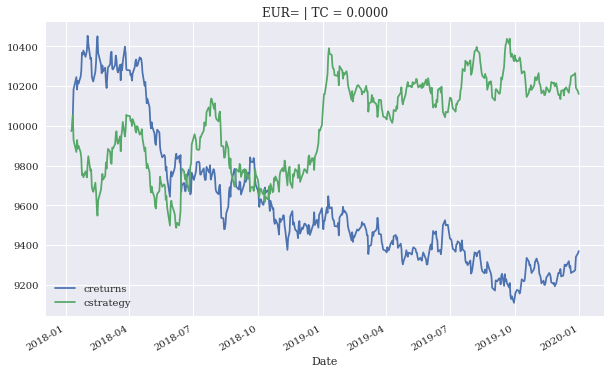

In [56]:
lrbt.plot_results()
# plt.savefig('../../images/ch05/lr_plot_7.png')

In [57]:
lrbt = LR.LRVectorBacktester('GDX', '2010-1-1', '2019-12-31',
                                     10000, 0.002)

In [58]:
lrbt.run_strategy('2010-1-1', '2019-12-31',
                  '2010-1-1', '2019-12-31', lags=7)  

(23642.32, 17649.69)

In [59]:
lrbt.run_strategy('2010-1-1', '2014-12-31',
                  '2015-1-1', '2019-12-31', lags=7)

(28513.35, 14888.41)

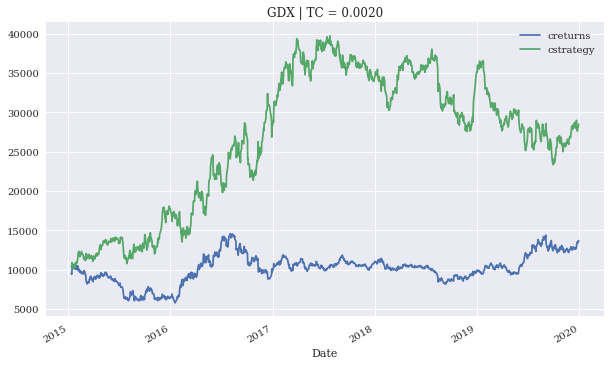

In [60]:
lrbt.plot_results()
# plt.savefig('../../images/ch05/lr_plot_8.png')

## Using Machine Learning for Market Movement Prediction

### Linear Regression with scikit-learn

In [61]:
x = np.arange(12)

In [62]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [63]:
lags = 3

In [64]:
m = np.zeros((lags + 1, len(x) - lags))

In [65]:
m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i:i - lags]

In [66]:
from sklearn import linear_model

In [67]:
lm = linear_model.LinearRegression()

In [68]:
lm.fit(m[:lags].T, m[lags])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
lm.coef_

array([0.33333333, 0.33333333, 0.33333333])

In [70]:
lm.intercept_

2.0

In [71]:
lm.predict(m[:lags].T)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [72]:
lm = linear_model.LinearRegression(fit_intercept=False)

In [73]:
lm.fit(m[:lags].T, m[lags])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [74]:
lm.coef_

array([-0.66666667,  0.33333333,  1.33333333])

In [75]:
lm.intercept_

0.0

In [76]:
lm.predict(m[:lags].T)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

### A Simple Classification Problem

In [77]:
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
                  2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
                  4.5, 4.75, 5., 5.5])

In [78]:
success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
                    0, 1, 1, 1, 1, 1, 1])

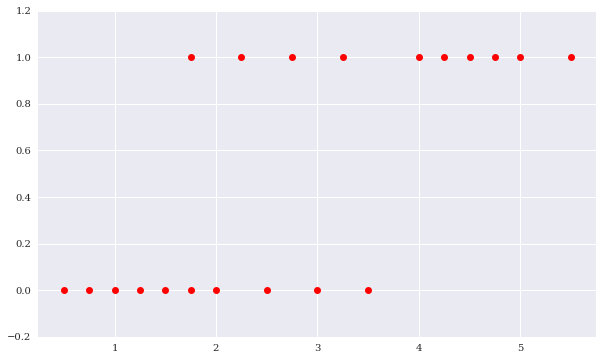

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.ylim(-0.2, 1.2);
# plt.savefig('../../images/ch05/ml_plot_1.png')

In [80]:
reg = np.polyfit(hours, success, deg=1)

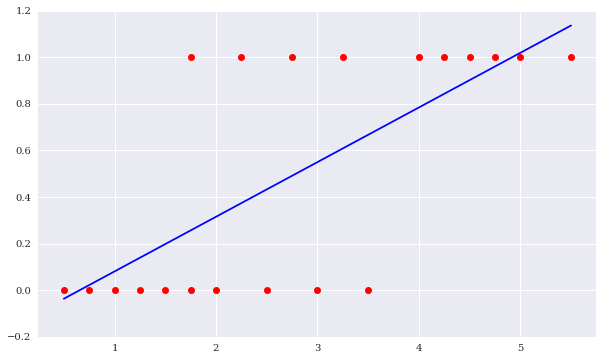

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.plot(hours, np.polyval(reg, hours), 'b')
plt.ylim(-0.2, 1.2);
# plt.savefig('../../images/ch05/ml_plot_2.png')

In [82]:
lm = linear_model.LogisticRegression(solver='lbfgs')

In [83]:
hrs = hours.reshape(1, -1).T

In [84]:
lm.fit(hrs, success)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
prediction = lm.predict(hrs)

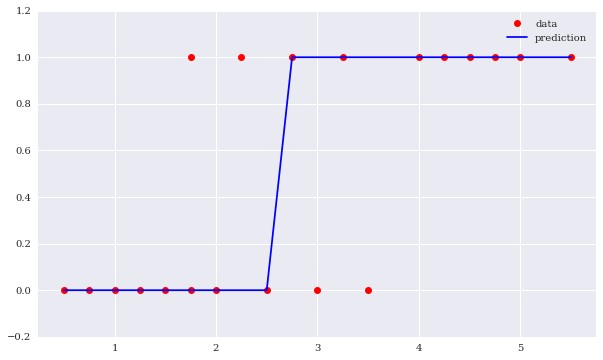

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro', label='data')
plt.plot(hours, prediction, 'b', label='prediction')
plt.legend(loc=0)
plt.ylim(-0.2, 1.2);
# plt.savefig('../../images/ch05/ml_plot_3.png')

In [87]:
prob = lm.predict_proba(hrs)

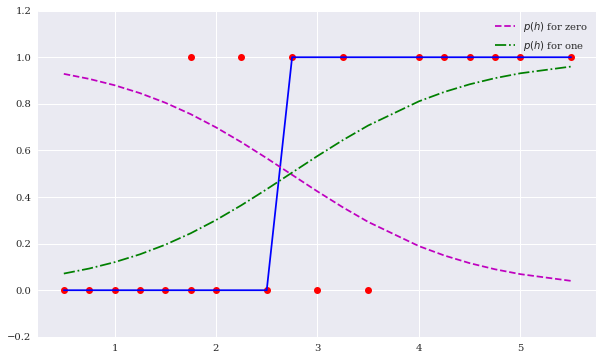

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.plot(hours, prediction, 'b')
plt.plot(hours, prob.T[0], 'm--',
         label='$p(h)$ for zero')
plt.plot(hours, prob.T[1], 'g-.',
         label='$p(h)$ for one')
plt.ylim(-0.2, 1.2)
plt.legend(loc=0);
# plt.savefig('../../images/ch05/ml_plot_4.png')

### Using Logistic Regression to Predict Market Direction

In [89]:
symbol = 'GLD'

In [90]:
data = pd.DataFrame(raw[symbol])

In [91]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [92]:
data['return'] = np.log(data['price'] / data['price'].shift(1))

In [93]:
data.dropna(inplace=True)

In [94]:
lags = 3

In [95]:
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['return'].shift(lag)
    cols.append(col)

In [96]:
data.dropna(inplace=True)

In [97]:
from sklearn.metrics import accuracy_score

In [98]:
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=1000)

In [99]:
lm.fit(data[cols], np.sign(data['return']))

LogisticRegression(C=10000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [100]:
data['prediction'] = lm.predict(data[cols])

In [101]:
data['prediction'].value_counts()

 1.0    1983
-1.0     529
Name: prediction, dtype: int64

In [102]:
hits = np.sign(data['return'].iloc[lags:] *
               data['prediction'].iloc[lags:]
              ).value_counts()

In [103]:
hits

 1.0    1338
-1.0    1159
 0.0      12
dtype: int64

In [104]:
accuracy_score(data['prediction'],
               np.sign(data['return']))

0.5338375796178344

In [105]:
data['strategy'] = data['prediction'] * data['return']

In [106]:
data[['return', 'strategy']].sum().apply(np.exp)

return      1.289478
strategy    2.458716
dtype: float64

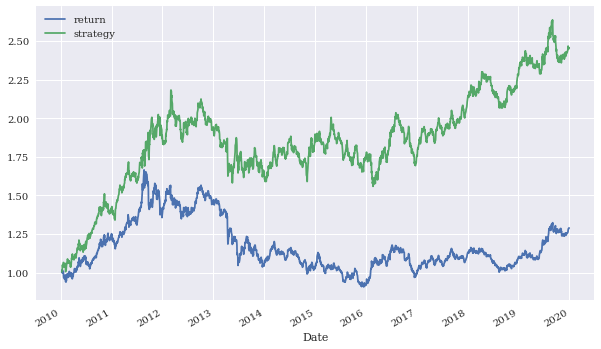

In [107]:
data[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(10, 6));
# plt.savefig('../../images/ch05/ml_plot_5.png')

In [108]:
data = pd.DataFrame(raw[symbol])

In [109]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [110]:
data['return'] = np.log(data['price'] / data['price'].shift(1))

In [111]:
lags = 5

In [112]:
cols = []
for lag in range(1, lags + 1):
    col = 'lag_%d' % lag
    data[col] = data['price'].shift(lag)
    cols.append(col)

In [113]:
data.dropna(inplace=True)

In [114]:
lm.fit(data[cols], np.sign(data['return']))

LogisticRegression(C=10000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [115]:
data['prediction'] = lm.predict(data[cols])

In [116]:
data['prediction'].value_counts()

 1.0    2047
-1.0     464
Name: prediction, dtype: int64

In [117]:
hits = np.sign(data['return'].iloc[lags:] *
               data['prediction'].iloc[lags:]
              ).value_counts()

In [118]:
hits

 1.0    1331
-1.0    1163
 0.0      12
dtype: int64

In [119]:
accuracy_score(data['prediction'],
               np.sign(data['return']))

0.5312624452409399

In [120]:
data['strategy'] = data['prediction'] * data['return']

In [121]:
data[['return', 'strategy']].sum().apply(np.exp)

return      1.283110
strategy    2.656833
dtype: float64

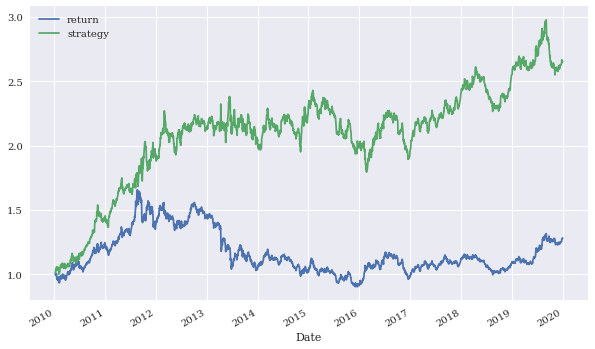

In [122]:
data[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(10, 6));
# plt.savefig('../../images/ch05/ml_plot_6.png')

### Generalizing the Approach

In [123]:
import ScikitVectorBacktester as SCI

In [124]:
scibt = SCI.ScikitVectorBacktester('EUR=',
                                   '2010-1-1', '2019-12-31',
                                   10000, 0.0, 'logistic')

In [125]:
scibt.run_strategy('2015-1-1', '2019-12-31',
                   '2015-1-1', '2019-12-31', lags=15)

(12192.18, 2189.5)

In [126]:
scibt.run_strategy('2016-1-1', '2018-12-31',
                   '2019-1-1', '2019-12-31', lags=15)

(10580.54, 729.93)

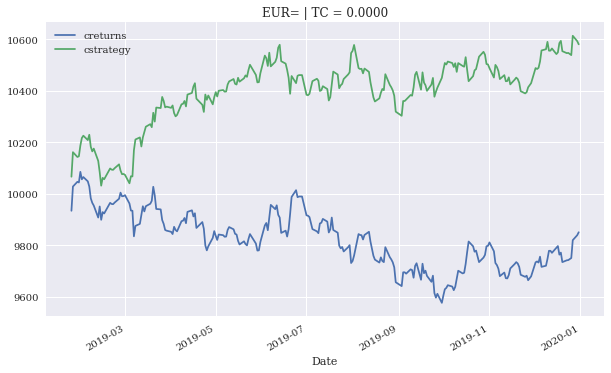

In [127]:
scibt.plot_results()
# plt.savefig('../../images/ch05/ml_plot_7.png')

In [128]:
scibt = SCI.ScikitVectorBacktester('GDX',
                                   '2010-1-1', '2019-12-31',
                                   10000, 0.00, 'logistic')

In [129]:
scibt.run_strategy('2013-1-1', '2017-12-31',
                   '2018-1-1', '2018-12-31', lags=10)

(12686.81, 4032.73)

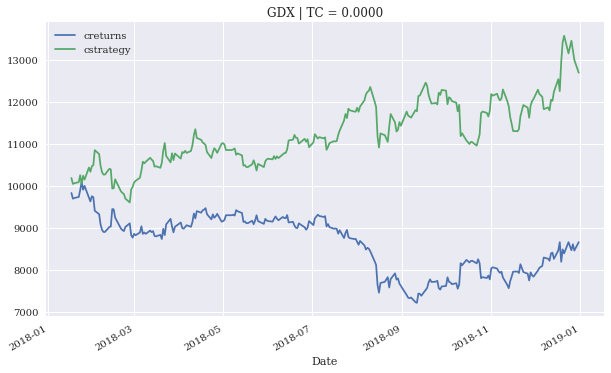

In [130]:
scibt.plot_results()
# plt.savefig('../../images/ch05/ml_plot_8.png')

In [131]:
scibt = SCI.ScikitVectorBacktester('GDX',
                                   '2010-1-1', '2019-12-31',
                                   10000, 0.0025, 'logistic')

In [132]:
scibt.run_strategy('2013-1-1', '2017-12-31',
                   '2018-1-1', '2018-12-31', lags=10)

(9588.48, 934.4)

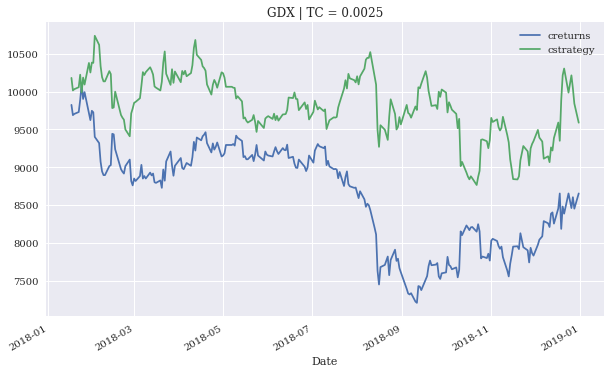

In [133]:
scibt.plot_results()
# plt.savefig('../../images/ch05/ml_plot_8_a.png')

## Using Deep Learning for Market Movement Prediction

#### The Simple Classification Problem Revisited 

In [134]:
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
                  2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
                  4.5, 4.75, 5., 5.5])

In [135]:
success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
                    0, 1, 1, 1, 1, 1, 1]) 

In [136]:
data = pd.DataFrame({'hours': hours, 'success': success})

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   hours    20 non-null     float64
 1   success  20 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 448.0 bytes


In [138]:
from sklearn.neural_network import MLPClassifier

In [139]:
model = MLPClassifier(hidden_layer_sizes=[32],
                     max_iter=1000, random_state=100)

In [140]:
model.fit(data['hours'].values.reshape(-1, 1), data['success'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[32], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=100, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [141]:
data['prediction'] = model.predict(data['hours'].values.reshape(-1, 1)) # <2>

In [142]:
data.tail()

,hours,success,prediction
15,4.25,1,1
16,4.50,1,1
17,4.75,1,1
18,5.00,1,1
19,5.50,1,1


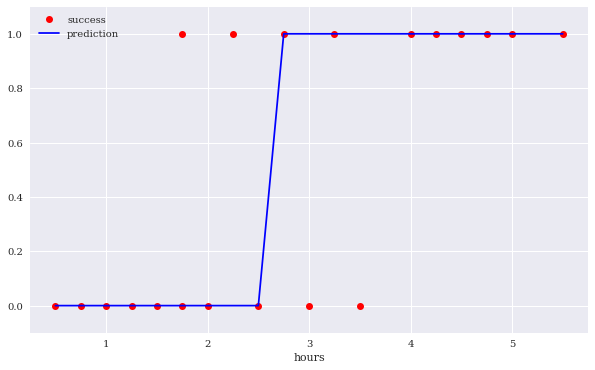

In [143]:
data.plot(x='hours', y=['success', 'prediction'],
          style=['ro', 'b-'], ylim=[-.1, 1.1],
          figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_1.png')

### Using Deep Neural Networks to Predict Market Direction

In [144]:
symbol = 'EUR='

In [145]:
data = pd.DataFrame(raw[symbol])

In [146]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [147]:
data['return'] = np.log(data['price'] /
                         data['price'].shift(1)) 

In [148]:
data['direction'] = np.where(data['return'] > 0, 1, 0)

In [149]:
lags = 5


In [150]:
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [151]:
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007


In [152]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam

Using TensorFlow backend.


In [153]:
optimizer = adam(learning_rate=0.0001)

In [154]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [155]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
        input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # <5>
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [156]:
cutoff = '2017-12-31'

In [157]:
training_data = data[data.index < cutoff].copy()

In [158]:
mu, std = training_data.mean(), training_data.std()

In [159]:
training_data_ = (training_data - mu) / std

In [160]:
test_data = data[data.index >= cutoff].copy()

In [161]:
test_data_ = (test_data - mu) / std

In [162]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

CPU times: user 5.15 s, sys: 919 ms, total: 6.07 s
Wall time: 3.33 s


In [163]:
res = pd.DataFrame(model.history.history)

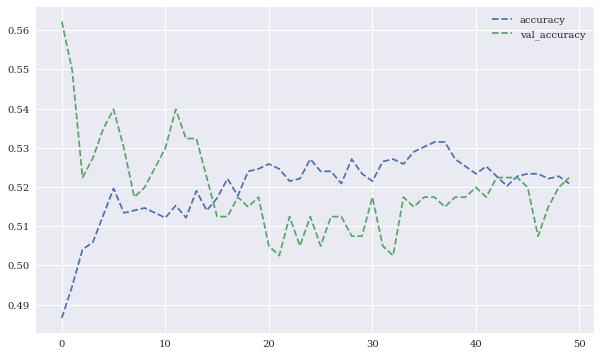

In [164]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');
# plt.savefig('../../images/ch05/dnn_plot_metrics.png')

In [165]:
model.evaluate(training_data_[cols], training_data['direction'])

2007/2007 [==============================] - 0s 15us/step


[0.7528249417957407, 0.5151968002319336]

In [166]:
pred = model.predict_classes(training_data_[cols])

In [167]:
pred[:30].flatten()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1], dtype=int32)

In [168]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [169]:
training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])

In [170]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.826569
strategy    1.238151
dtype: float64

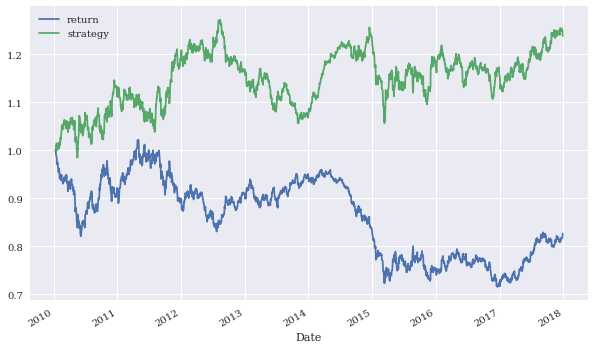

In [171]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_2.png')

In [172]:
model.evaluate(test_data_[cols], test_data['direction'])

503/503 [==============================] - 0s 29us/step


[0.7452366796449923, 0.4811133146286011]

In [173]:
pred = model.predict_classes(test_data_[cols])

In [174]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [175]:
test_data['prediction'].value_counts()

-1    256
 1    247
Name: prediction, dtype: int64

In [176]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [177]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.026139
dtype: float64

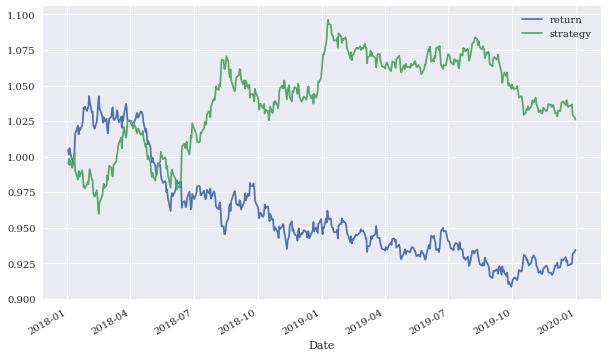

In [178]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_3.png')

### Adding Different Types of Features

In [179]:
data['momentum'] = data['return'].rolling(5).mean().shift(1)

In [180]:
data['volatility'] = data['return'].rolling(20).std().shift(1)

In [181]:
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)

In [182]:
data.dropna(inplace=True)

In [183]:
cols.extend(['momentum', 'volatility', 'distance'])

In [184]:
print(data.round(4).tail())

             price  return  direction   lag_1   lag_2   lag_3   lag_4   lag_5  \
Date                                                                            
2019-12-24  1.1087  0.0001          1  0.0007 -0.0038  0.0008 -0.0034  0.0006   
2019-12-26  1.1096  0.0008          1  0.0001  0.0007 -0.0038  0.0008 -0.0034   
2019-12-27  1.1175  0.0071          1  0.0008  0.0001  0.0007 -0.0038  0.0008   
2019-12-30  1.1197  0.0020          1  0.0071  0.0008  0.0001  0.0007 -0.0038   
2019-12-31  1.1210  0.0012          1  0.0020  0.0071  0.0008  0.0001  0.0007   

            momentum  volatility  distance  
Date                                        
2019-12-24   -0.0010      0.0024    0.0005  
2019-12-26   -0.0011      0.0024    0.0004  
2019-12-27   -0.0003      0.0024    0.0012  
2019-12-30    0.0010      0.0028    0.0089  
2019-12-31    0.0021      0.0028    0.0110  


In [185]:
training_data = data[data.index < cutoff].copy()

In [186]:
mu, std = training_data.mean(), training_data.std()

In [187]:
training_data_ = (training_data - mu) / std

In [188]:
test_data = data[data.index >= cutoff].copy() 

In [189]:
test_data_ = (test_data - mu) / std

In [190]:
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [191]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

CPU times: user 2.9 s, sys: 483 ms, total: 3.38 s
Wall time: 1.99 s


In [192]:
model.evaluate(training_data_[cols], training_data['direction'])

1957/1957 [==============================] - 0s 23us/step


[0.6812173691585348, 0.5462442636489868]

In [193]:
pred = model.predict_classes(training_data_[cols])

In [194]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [195]:
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']

In [196]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.901074
strategy    1.815211
dtype: float64

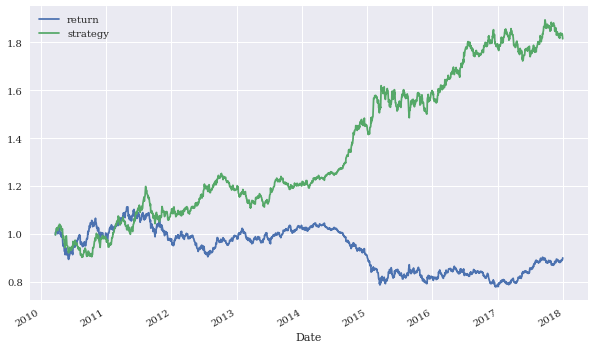

In [197]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_4.png')

In [198]:
model.evaluate(test_data_[cols], test_data['direction'])

503/503 [==============================] - 0s 22us/step


[0.6964824583611005, 0.4990059733390808]

In [199]:
pred = model.predict_classes(test_data_[cols])

In [200]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [201]:
test_data['prediction'].value_counts()

-1    339
 1    164
Name: prediction, dtype: int64

In [202]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [203]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.109780
dtype: float64

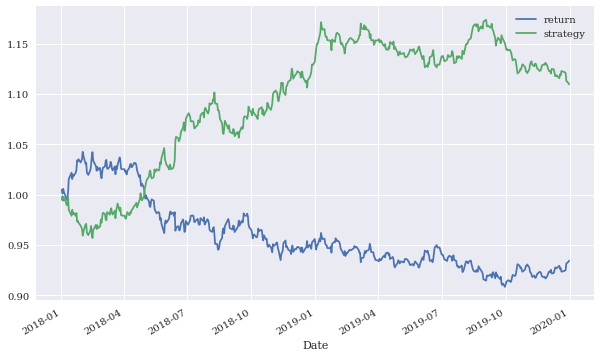

In [204]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_5.png')

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>